# Regression

In [ ]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

from google.colab import drive
drive.mount('/content/drive')

sys.path.append("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks")
from auxillary_functions import *
from polyfeat_imp import *
from polynomial_featextract import poly_featextract

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import raw data and params.txt file
datadir_path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-21_classify_datagen_all_funcs"

rawdata = load_data(datadir_path)
params = load_params(datadir_path)
ker_integrals = load_wlist(datadir_path) # load wlist.txt file

# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

Finished loading rawdata into numpy array
Finsihed loading parameters file
finished loading kernel-integrals file.


In [ ]:
print(rawdata.shape)
offset = 150
shifted_data, center = get_window(rawdata,2/3,width=offset)
print("The Echo pulse occurs at timestep:",center)

# Rescaled data
rscl_data = shifted_data / np.max(shifted_data,axis=1,keepdims=True)

(10500, 943)
The Echo pulse occurs at timestep: 628


In [ ]:
y_classes = get_yclasses(params, ker_integrals)
y_classes.head(10)

,αx,αz,len_scale
0,0.000140,0.004113,3.471444
1,0.000288,0.005442,2.838588
2,0.000948,0.000869,4.783256
3,0.008380,0.014527,1.950423
4,0.000710,0.013350,1.764475
5,0.002684,0.009202,2.821678
6,0.009862,0.004989,2.148588
7,0.012009,0.011066,1.546340
8,0.004234,0.001067,2.726702
9,0.006289,0.001765,2.357856


## Pointwise features

In [ ]:
def get_r2_barplot(fi_dataframe:pd.DataFrame, axes, kind):
    """Plots the combined-barchart for the feature-importance dataset"""
    cv_mean, cv_std = np.array([i[0] for i in fi_dataframe.score_stats]), np.array([i[1] for i in fi_dataframe.score_stats])
    X = [str(i) for i in fi_dataframe.n_features]

    if kind=='timeseries':
        axes.bar(x=np.arange(len(X))-0.3, height=cv_mean, yerr=cv_std, width=0.25, color='b')
        axes.bar(x=np.arange(len(X)), height=fi_dataframe.oob_score, width=0.25, color='y')
        axes.bar(x=np.arange(len(X))+0.3, height=fi_dataframe.test_score, width=0.25, color='g')
        axes.set(xticks=np.arange(len(X)), xticklabels=X)

        return axes

    if kind=='polyfeats':
        zeros = np.array([0,0])
        cv_scores_pf_mean_p = np.hstack((zeros, cv_mean))
        cv_scores_pf_std_p = np.hstack((zeros, cv_std))
        oob_scores_pf_p = np.hstack((zeros, fi_dataframe.oob_score))
        test_scores_pf_p  = np.hstack((zeros, fi_dataframe.test_score))

        axes.bar(x=np.arange(len(X)+2)-0.3, height=-cv_scores_pf_mean_p, yerr=cv_scores_pf_std_p, width=0.25, color='b')
        axes.bar(x=np.arange(len(X)+2), height=-oob_scores_pf_p, width=0.25, color='y')
        axes.bar(x=np.arange(len(X)+2)+0.3, height=-test_scores_pf_p, width=0.25, color='g')
        axes.set(xticks=np.arange(len(X)), xticklabels=X)

        return axes

In [ ]:
import sklearn 
from sklearn.base import clone
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [ ]:
rscl_df = pd.DataFrame(rscl_data, 
                       columns=[F'feat{i+1}' for i in range(len(rscl_data[0]+1))])
rscl_df.head()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30,feat31,feat32,feat33,feat34,feat35,feat36,feat37,feat38,feat39,feat40,...,feat261,feat262,feat263,feat264,feat265,feat266,feat267,feat268,feat269,feat270,feat271,feat272,feat273,feat274,feat275,feat276,feat277,feat278,feat279,feat280,feat281,feat282,feat283,feat284,feat285,feat286,feat287,feat288,feat289,feat290,feat291,feat292,feat293,feat294,feat295,feat296,feat297,feat298,feat299,feat300
0,0.007752,0.007970,0.007859,0.007362,0.006486,0.005304,0.003966,0.002714,0.001994,0.002240,0.003050,0.003977,0.004912,0.005853,0.006821,0.007831,0.008886,0.009962,0.010987,0.011842,0.012395,0.012538,0.012233,0.011535,0.010597,0.009640,0.008909,0.008615,0.008896,0.009777,0.011158,0.012818,0.014456,0.015753,0.016443,0.016368,0.015518,0.014031,0.012173,0.010274,...,0.007232,0.008779,0.010651,0.012499,0.013974,0.014804,0.014843,0.014102,0.012740,0.011034,0.009314,0.007892,0.007006,0.006765,0.007147,0.008007,0.009117,0.010217,0.011072,0.011524,0.011516,0.011093,0.010370,0.009490,0.008576,0.007702,0.006896,0.006155,0.005456,0.004751,0.003979,0.003113,0.002297,0.002097,0.002921,0.004195,0.005431,0.006386,0.006943,0.007078
1,0.007954,0.008204,0.008141,0.007703,0.006886,0.005750,0.004428,0.003127,0.002203,0.002156,0.002860,0.003798,0.004777,0.005768,0.006779,0.007827,0.008917,0.010024,0.011077,0.011962,0.012546,0.012728,0.012472,0.011835,0.010966,0.010080,0.009416,0.009176,0.009490,0.010383,0.011755,0.013390,0.014990,0.016243,0.016885,0.016765,0.015876,0.014360,0.012483,0.010577,...,0.007048,0.008521,0.010312,0.012065,0.013431,0.014139,0.014050,0.013184,0.011710,0.009914,0.008133,0.006691,0.005825,0.005651,0.006139,0.007133,0.008391,0.009640,0.010638,0.011223,0.011338,0.011026,0.010407,0.009622,0.008794,0.007998,0.007270,0.006617,0.006022,0.005428,0.004746,0.003904,0.002948,0.002241,0.002522,0.003646,0.004908,0.005939,0.006574,0.006770
2,0.008362,0.008377,0.008070,0.007380,0.006320,0.005004,0.003705,0.002974,0.003336,0.004407,0.005636,0.006833,0.007985,0.009136,0.010327,0.011577,0.012878,0.014184,0.015409,0.016428,0.017104,0.017328,0.017059,0.016351,0.015362,0.014322,0.013497,0.013124,0.013367,0.014270,0.015734,0.017530,0.019332,0.020792,0.021610,0.021597,0.020720,0.019109,0.017034,0.014844,...,0.006680,0.004955,0.003161,0.002609,0.003653,0.004712,0.005075,0.004610,0.003449,0.001902,0.000592,0.001249,0.001900,0.001845,0.001082,0.000412,0.001964,0.003593,0.004948,0.005842,0.006216,0.006138,0.005770,0.005298,0.004852,0.004459,0.004079,0.003681,0.003262,0.002817,0.002313,0.001764,0.001522,0.002185,0.003444,0.004810,0.005980,0.006746,0.006991,0.006697
3,0.071041,0.116141,0.157928,0.186144,0.193928,0.176297,0.131342,0.063197,0.047574,0.143523,0.244109,0.331524,0.394783,0.427744,0.430725,0.411673,0.385972,0.372340,0.382148,0.410700,0.443466,0.467947,0.478935,0.478557,0.474363,0.476278,0.492618,0.526711,0.576429,0.636274,0.699532,0.759315,0.808905,0.842098,0.853650,0.839802,0.798746,0.730959,0.639387,0.529448,...,0.235294,0.135007,0.063859,0.099112,0.173708,0.244687,0.307738,0.362627,0.409473,0.448187,0.478734,0.501774,0.519287,0.534609,0.551404,0.571638,0.593824,0.613037,0.622808,0.617796,0.595924,0.559370,0.514321,0.469429,0.433229,0.411235,0.404521,0.410693,0.425682,0.444243,0.459769,0.464925,0.453342,0.421539,0.370215,0.304493,0.233116,0.166677,0.114716,0.081142
4,0.008419,0.008817,0.008915,0.008637,0.007955,0.006909,0.005599,0.004194,0.002949,0.002305,0.002617,0.003497,0.004533,0.005599,0.006677,0.007779,0.008908,0.010039,0.011106,0.012004,0.012620,0.012869,0.012727,0.012255,0.011597,0.010952,0.010531,0.010513,0.011006,0.012017,0.013439,0.015058,0.016584,0.017720,0.018223,0.017961,0.016947,0.015341,0.013419,0.011513,...,0.006159,0.007627,0.009420,0.011146,0.012434,0.013009,0.012752,0.011716,0.010124,0.008314,0.006670,0.005512,0.004990,0.005112,0.005866

### $\alpha _x$

In [ ]:
X_train_ax_ts , X_test_ax_ts, y_train_ax_ts, y_test_ax_ts = train_test_split(rscl_df, y_classes['αx'], test_size=0.2,
                                                     stratify=params['stencil_type'], random_state=101)

In [ ]:
basemodel_ax_ts = RandomForestRegressor(n_estimators=100, min_samples_split=5, max_features=0.5, 
                           n_jobs=-1, oob_score=True, verbose=1)
basemodel_ax_ts.fit(X_train_ax_ts, y_train_ax_ts)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=1, warm_start=False)

In [ ]:
basemodel_ax_ts.score(X_test_ax_ts, y_test_ax_ts)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


0.9665569648593241

In [ ]:
print('OOB Score: ', basemodel_ax_ts.oob_score_)

OOB Score:  0.9628102469570196


#### Feature importance

     feature        fi
116  feat117  0.070085
126  feat127  0.045149
69    feat70  0.040831
44    feat45  0.033578
127  feat128  0.032458
68    feat69  0.031548
43    feat44  0.029677
115  feat116  0.023445
88    feat89  0.021502
45    feat46  0.020736


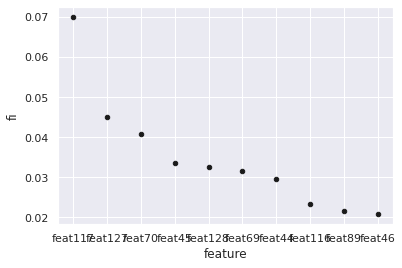

In [ ]:
fi_ts_ax = get_fi(basemodel_ax_ts, rscl_df,'timeseries')
fi_ts_ax[:10].plot.scatter('feature', 'fi', color='k')
print(fi_ts_ax[:10])

In [ ]:
ts_ax_fi_data = features_vs_r2(rscl_df, 'timeseries', y=y_classes['αx'], 
               model=basemodel_ax_ts, test_size=0.2, cv=3, niters=8, stratify=params['stencil_type'], as_df=True)

Running iter 1
Number of features: 300
Size of training and test set: ((8400, 300), (2100, 300))
Computing cross-validation scores
Cross val-scores: 0.952 +- 0.000381
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


Model Out-of-Bag score: 0.962
Test score: 0.966


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Running iter 2
Number of features: 150
Size of training and test set: ((8400, 150), (2100, 150))
Computing cross-validation scores
Cross val-scores: 0.953 +- 0.00121
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.1s finished


Model Out-of-Bag score: 0.963
Test score: 0.966


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Running iter 3
Number of features: 75
Size of training and test set: ((8400, 75), (2100, 75))
Computing cross-validation scores
Cross val-scores: 0.948 +- 0.00138
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s


Model Out-of-Bag score: 0.959
Test score: 0.962


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished



Running iter 4
Number of features: 38
Size of training and test set: ((8400, 38), (2100, 38))
Computing cross-validation scores
Cross val-scores: 0.939 +- 0.000286
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.9s finished


Model Out-of-Bag score: 0.95
Test score: 0.953


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Running iter 5
Number of features: 19
Size of training and test set: ((8400, 19), (2100, 19))
Computing cross-validation scores
Cross val-scores: 0.926 +- 0.00132
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished


Model Out-of-Bag score: 0.937
Test score: 0.937


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Running iter 6
Number of features: 10
Size of training and test set: ((8400, 10), (2100, 10))
Computing cross-validation scores
Cross val-scores: 0.892 +- 0.00416
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Out-of-Bag score: 0.905
Test score: 0.9

Running iter 7
Number of features: 5
Size of training and test set: ((8400, 5), (2100, 5))
Computing cross-validation scores
Cross val-scores: 0.815 +- 0.00529
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Model Out-of-Bag score: 0.832
Test score: 0.842


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Running iter 8
Number of features: 3
Size of training and test set: ((8400, 3), (2100, 3))
Computing cross-validation scores
Cross val-scores: 0.665 +- 0.00314
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s


Model Out-of-Bag score: 0.676
Test score: 0.667



[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
ts_ax_fi_data

,n_features,features,model_obj,feat_imp,score_stats,oob_score,test_score
0,300,"[feat1, feat2, feat3, feat4, feat5, feat6, fea...","(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",116 0.073483 127 0.056580 126 0.05367...,"[0.9521482214160794, 0.000380971730983768]",0.962429,0.966021
1,150,116 feat117 127 feat128 126 feat127 4...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.067010 7 0.051641 5 0.04337...,"[0.9526164885216769, 0.0012108245608275286]",0.963169,0.965673
2,75,0 feat117 7 feat70 5 feat116 3...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.078646 1 0.053174 3 0.046134 5...,"[0.9483254218452712, 0.0013847216968820692]",0.958505,0.961989
3,38,0 feat117 1 feat70 3 feat45 5 ...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.089112 2 0.051884 1 0.046336 5...,"[0.9390500831359585, 0.0002858629155309808]",0.949814,0.953102
4,19,0 feat117 2 feat45 1 feat70 5 ...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.095989 5 0.075285 7 0.071567 1...,"[0.926499255621735, 0.0013230824974181676]",0.936588,0.936708
5,10,0 feat117 5 feat128 7 feat127 1 ...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",3 0.176188 0 0.119882 5 0.101978 4 ...,"[0.8924449942194214, 0.004157304879449964]",0.905173,0.900285
6,5,3 feat45 0 feat117 5 feat280 4 f...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",3 0.223644 0 0.221638 4 0.211832 1 ...,"[0.815406639310632, 0.005287298900001081]",0.831501,0.841630
7,3,3 feat70 0 feat45 4 feat127 Name: f...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.339320 1 0.338117 2 0.322563 Name...,"[0.6647611809867512, 0.003135264370005585]",0.676399,0.666888


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


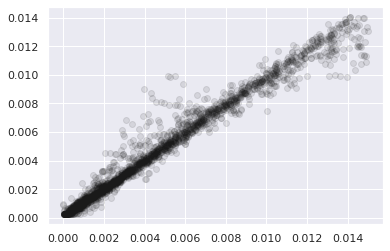

In [ ]:
y_pred_ax_ts = ts_ax_fi_data.iloc[0,2].predict(X_test_ax_ts)

plt.plot(y_test_ax_ts, y_pred_ax_ts,'ko',alpha=0.1)
plt.show()

### $\alpha _z$ 

In [ ]:
X_train_az_ts , X_test_az_ts, y_train_az_ts, y_test_az_ts = train_test_split(rscl_df, y_classes['αz'], test_size=0.2,
                                                     stratify=params['stencil_type'], random_state=101)

In [ ]:
basemodel_az_ts = RandomForestRegressor(n_estimators=100, min_samples_split=5, max_features=0.5, 
                           n_jobs=-1, oob_score=True, verbose=1)
basemodel_az_ts.fit(X_train_az_ts, y_train_az_ts)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=1, warm_start=False)

In [ ]:
basemodel_az_ts.score(X_test_az_ts, y_test_az_ts)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


0.9649696149248189

In [ ]:
basemodel_az_ts.oob_score_

0.9674702989047151

#### feature importance

     feature        fi
137  feat138  0.086762
138  feat139  0.068166
139  feat140  0.064944
11    feat12  0.040709
143  feat144  0.033547
151  feat152  0.029881
264  feat265  0.029401
265  feat266  0.027775
12    feat13  0.027128
47    feat48  0.025202


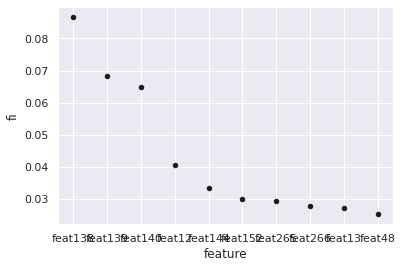

In [ ]:
fi_ts_az = get_fi(basemodel_az_ts, rscl_df,'timeseries')
fi_ts_az[:10].plot.scatter('feature', 'fi', color='k')
print(fi_ts_az[:10])

In [ ]:
ts_az_fi_data = features_vs_r2(rscl_df, 'timeseries', y=y_classes['αz'], 
               model=basemodel_az_ts, test_size=0.2, cv=3, niters=8, stratify=params['stencil_type'], as_df=True)

Running iter 1
Number of features: 300
Size of training and test set: ((8400, 300), (2100, 300))
Computing cross-validation scores
Cross val-scores: 0.959 +- 0.000799
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


Model Out-of-Bag score: 0.967
Test score: 0.966


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Running iter 2
Number of features: 150
Size of training and test set: ((8400, 150), (2100, 150))
Computing cross-validation scores
Cross val-scores: 0.96 +- 0.00127
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.8s finished


Model Out-of-Bag score: 0.967
Test score: 0.965


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Running iter 3
Number of features: 75
Size of training and test set: ((8400, 75), (2100, 75))
Computing cross-validation scores
Cross val-scores: 0.958 +- 0.00137
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.3s finished


Model Out-of-Bag score: 0.966
Test score: 0.965


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Running iter 4
Number of features: 38
Size of training and test set: ((8400, 38), (2100, 38))
Computing cross-validation scores
Cross val-scores: 0.953 +- 0.00174
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s finished


Model Out-of-Bag score: 0.963
Test score: 0.96


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished



Running iter 5
Number of features: 19
Size of training and test set: ((8400, 19), (2100, 19))
Computing cross-validation scores
Cross val-scores: 0.942 +- 0.00234
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Model Out-of-Bag score: 0.951
Test score: 0.948


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Running iter 6
Number of features: 10
Size of training and test set: ((8400, 10), (2100, 10))
Computing cross-validation scores
Cross val-scores: 0.911 +- 0.00275
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Model Out-of-Bag score: 0.924
Test score: 0.923


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Running iter 7
Number of features: 5
Size of training and test set: ((8400, 5), (2100, 5))
Computing cross-validation scores
Cross val-scores: 0.904 +- 0.00332
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Out-of-Bag score: 0.915
Test score: 0.918

Running iter 8
Number of features: 3
Size of training and test set: ((8400, 3), (2100, 3))
Computing cross-validation scores
Cross val-scores: 0.777 +- 0.00155
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished


Model Out-of-Bag score: 0.784
Test score: 0.793


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
ts_az_fi_data

,n_features,features,model_obj,feat_imp,score_stats,oob_score,test_score
0,300,"[feat1, feat2, feat3, feat4, feat5, feat6, fea...","(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",116 0.073483 127 0.056580 126 0.05367...,"[0.9521482214160794, 0.000380971730983768]",0.962429,0.966021
1,150,116 feat117 127 feat128 126 feat127 4...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.067010 7 0.051641 5 0.04337...,"[0.9526164885216769, 0.0012108245608275286]",0.963169,0.965673
2,75,0 feat117 7 feat70 5 feat116 3...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.078646 1 0.053174 3 0.046134 5...,"[0.9483254218452712, 0.0013847216968820692]",0.958505,0.961989
3,38,0 feat117 1 feat70 3 feat45 5 ...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.089112 2 0.051884 1 0.046336 5...,"[0.9390500831359585, 0.0002858629155309808]",0.949814,0.953102
4,19,0 feat117 2 feat45 1 feat70 5 ...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.095989 5 0.075285 7 0.071567 1...,"[0.926499255621735, 0.0013230824974181676]",0.936588,0.936708
5,10,0 feat117 5 feat128 7 feat127 1 ...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",3 0.176188 0 0.119882 5 0.101978 4 ...,"[0.8924449942194214, 0.004157304879449964]",0.905173,0.900285
6,5,3 feat45 0 feat117 5 feat280 4 f...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",3 0.223644 0 0.221638 4 0.211832 1 ...,"[0.815406639310632, 0.005287298900001081]",0.831501,0.841630
7,3,3 feat70 0 feat45 4 feat127 Name: f...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.339320 1 0.338117 2 0.322563 Name...,"[0.6647611809867512, 0.003135264370005585]",0.676399,0.666888


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


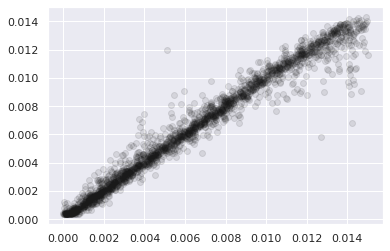

In [ ]:
y_pred_az_ts = ts_az_fi_data.iloc[0,2].predict(X_test_az_ts)

plt.plot(y_test_az_ts, y_pred_az_ts,'ko',alpha=0.1)
plt.show()

### Length-scale $\sqrt{w/\sum \alpha}$

In [ ]:
X_train_ls_ts , X_test_ls_ts, y_train_ls_ts, y_test_ls_ts = train_test_split(rscl_df, y_classes['len_scale'], test_size=0.2,
                                                     stratify=None, random_state=101)

In [ ]:
basemodel_ls_ts = RandomForestRegressor(n_estimators=100, min_samples_split=3, max_features='sqrt',
                           n_jobs=-1, oob_score=True, verbose=1)
basemodel_ls_ts.fit(X_train_ls_ts, y_train_ls_ts)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.5s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=1, warm_start=False)

In [ ]:
basemodel_ls_ts.score(X_test_ls_ts, y_test_ls_ts)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


0.9099931709239678

In [ ]:
basemodel_ls_ts.oob_score_

0.8316530609605188

#### feature importance

     feature        fi
284  feat285  0.024731
283  feat284  0.020217
286  feat287  0.017870
285  feat286  0.017050
287  feat288  0.016146
255  feat256  0.015047
281  feat282  0.013549
288  feat289  0.013294
289  feat290  0.013069
254  feat255  0.012390


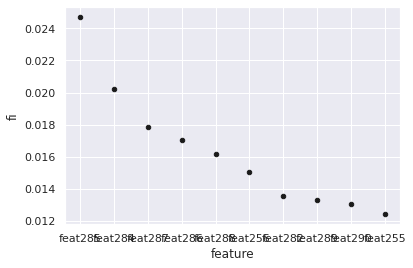

In [ ]:
fi_ts_ls = get_fi(basemodel_ls_ts, rscl_df,'timeseries')
fi_ts_ls[:10].plot.scatter('feature', 'fi', color='k')
print(fi_ts_ls[:10])

In [ ]:
ts_ls_fi_data = features_vs_r2(rscl_df, 'timeseries', y=y_classes['len_scale'], 
               model=basemodel_ls_ts, test_size=0.2, cv=5, niters=8, stratify=None, as_df=True)

Running iter 1
Number of features: 300
Size of training and test set: ((8400, 300), (2100, 300))
Computing cross-validation scores
Cross val-scores: 0.83 +- 0.0588
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.3s finished


Model Out-of-Bag score: 0.819
Test score: 0.889


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished



Running iter 2
Number of features: 150
Size of training and test set: ((8400, 150), (2100, 150))
Computing cross-validation scores
Cross val-scores: 0.825 +- 0.0674
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.5s finished


Model Out-of-Bag score: 0.835
Test score: 0.893


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished



Running iter 3
Number of features: 75
Size of training and test set: ((8400, 75), (2100, 75))
Computing cross-validation scores
Cross val-scores: 0.831 +- 0.063
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished


Model Out-of-Bag score: 0.826
Test score: 0.894


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished



Running iter 4
Number of features: 38
Size of training and test set: ((8400, 38), (2100, 38))
Computing cross-validation scores
Cross val-scores: 0.819 +- 0.0638
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished


Model Out-of-Bag score: 0.815
Test score: 0.891


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished



Running iter 5
Number of features: 19
Size of training and test set: ((8400, 19), (2100, 19))
Computing cross-validation scores
Cross val-scores: 0.803 +- 0.0699
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s


Model Out-of-Bag score: 0.805
Test score: 0.874


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished



Running iter 6
Number of features: 10
Size of training and test set: ((8400, 10), (2100, 10))
Computing cross-validation scores
Cross val-scores: 0.751 +- 0.0867
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s


Model Out-of-Bag score: 0.747
Test score: 0.803


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished



Running iter 7
Number of features: 5
Size of training and test set: ((8400, 5), (2100, 5))
Computing cross-validation scores
Cross val-scores: 0.661 +- 0.0797
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Model Out-of-Bag score: 0.654
Test score: 0.711


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Running iter 8
Number of features: 3
Size of training and test set: ((8400, 3), (2100, 3))
Computing cross-validation scores
Cross val-scores: 0.438 +- 0.0732
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Model Out-of-Bag score: 0.426
Test score: 0.549


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
ts_ls_fi_data

,n_features,features,model_obj,feat_imp,score_stats,oob_score,test_score
0,300,"[feat1, feat2, feat3, feat4, feat5, feat6, fea...","(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",284 0.023854 286 0.019791 288 0.01841...,"[0.830484380123264, 0.05877560862320982]",0.818865,0.888923
1,150,284 feat285 286 feat287 288 feat289 2...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",3 0.024296 5 0.022727 0 0.02271...,"[0.8252648238203297, 0.06744562211397628]",0.835166,0.893159
2,75,3 feat286 5 feat284 0 feat285 7...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",2 0.028682 0 0.028073 4 0.027884 1...,"[0.8305069109325199, 0.0630462510956348]",0.825549,0.893764
3,38,2 feat285 0 feat286 4 feat287 10 ...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.042905 1 0.042121 35 0.038235 4...,"[0.8192076809597143, 0.06376595423083536]",0.814531,0.890890
4,19,0 feat285 1 feat286 35 feat218 4 ...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",1 0.068853 16 0.062144 11 0.059591 7...,"[0.8031025347003528, 0.06985381039298336]",0.805122,0.874477
5,10,1 feat286 16 feat287 11 feat251 7 ...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",5 0.120664 7 0.115378 9 0.112625 3 ...,"[0.7510367981343985, 0.08666855867412543]",0.747369,0.802968
6,5,5 feat212 7 feat285 9 feat258 3 f...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",2 0.220774 1 0.205662 4 0.202168 3 ...,"[0.6606547445001484, 0.07968607365897397]",0.653849,0.710727
7,3,2 feat258 1 feat285 4 feat286 Name: f...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.374453 2 0.319682 1 0.305866 Name...,"[0.43815739345672683, 0.07320627623235947]",0.426102,0.549092


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


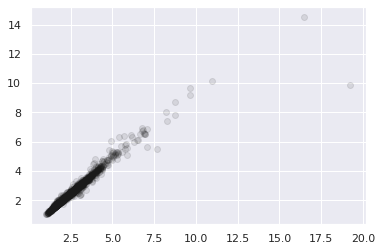

In [ ]:
y_pred_ls_ts = ts_ls_fi_data.iloc[0,2].predict(X_test_ls_ts)

plt.plot(y_test_ls_ts, y_pred_ls_ts,'ko',alpha=0.1)
plt.show()

## Timeseries R^2 barchart

[(0.4, 1.0)]

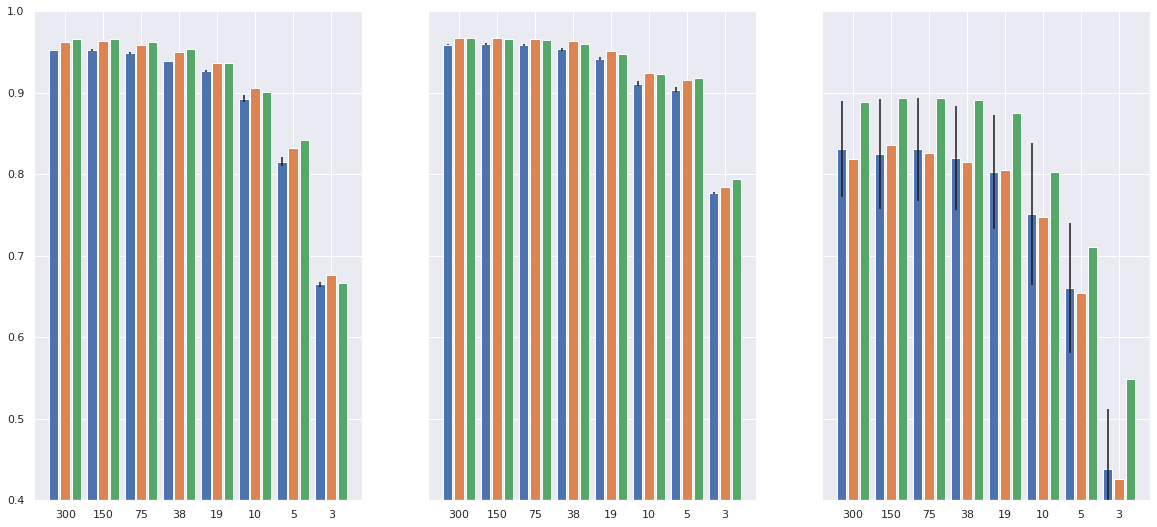

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,9),sharex=True, sharey=True)

get_r2_barplot(ts_ax_fi_data, ax1, 'timeseries')
get_r2_barplot(ts_az_fi_data, ax2, 'timeseries')
get_r2_barplot(ts_ls_fi_data, ax3, 'timeseries')

ax1.set(ylim=[0.40,1.0])

## Polynomial Features

In [ ]:
%time polyfeats = poly_featextract(rscl_data, n_splits=[4,5,10], order_fits=[3,3,3], as_df=True)
polyfeats.head()

CPU times: user 23 s, sys: 291 ms, total: 23.3 s
Wall time: 22.9 s


,4_1_3,4_1_2,4_1_1,4_1_0,4_2_3,4_2_2,4_2_1,4_2_0,4_3_3,4_3_2,4_3_1,4_3_0,4_4_3,4_4_2,4_4_1,4_4_0,5_1_3,5_1_2,5_1_1,5_1_0,5_2_3,5_2_2,5_2_1,5_2_0,5_3_3,5_3_2,5_3_1,5_3_0,5_4_3,5_4_2,5_4_1,5_4_0,5_5_3,5_5_2,5_5_1,5_5_0,10_1_3,10_1_2,10_1_1,10_1_0,10_2_3,10_2_2,10_2_1,10_2_0,10_3_3,10_3_2,10_3_1,10_3_0,10_4_3,10_4_2,10_4_1,10_4_0,10_5_3,10_5_2,10_5_1,10_5_0,10_6_3,10_6_2,10_6_1,10_6_0,10_7_3,10_7_2,10_7_1,10_7_0,10_8_3,10_8_2,10_8_1,10_8_0,10_9_3,10_9_2,10_9_1,10_9_0,10_10_3,10_10_2,10_10_1,10_10_0
0,2.236470e-07,0.000006,0.000135,0.011056,0.000004,0.000259,0.007989,0.151059,-0.000004,0.000274,-0.008279,0.146295,-2.149142e-07,6.155184e-06,-0.000127,0.010173,4.935042e-08,-9.564643e-07,0.000146,0.010836,0.000001,0.000088,0.002330,0.050902,-1.240648e-06,-0.000796,0.000025,0.788313,-0.000002,0.000088,-0.002004,0.043527,-1.111921e-07,-9.397075e-07,-0.000102,0.009810,-0.000004,3.937068e-07,0.000778,0.007660,2.546437e-08,0.000025,0.000113,0.011351,0.000003,0.000015,0.000244,0.031908,0.000005,0.000144,0.005397,0.110987,0.000009,0.000671,0.025493,0.506981,4.404496e-08,0.000656,-0.026719,0.493492,-0.000005,0.000145,-0.005154,0.099619,-3.561492e-06,0.000002,-0.000040,0.029204,0.000001,0.000023,-0.000220,0.010351,0.000003,-4.742971e-07,-0.000630,0.007237
1,2.215008e-07,0.000007,0.000148,0.011400,0.000004,0.000257,0.008087,0.155030,-0.000004,0.000277,-0.008140,0.139200,-2.150578e-07,5.847759e-06,-0.000100,0.009622,5.348174e-08,-7.629906e-07,0.000151,0.011101,0.000001,0.000088,0.002405,0.052983,-8.409482e-07,-0.000797,-0.000491,0.787621,-0.000002,0.000088,-0.001867,0.039771,-8.054796e-08,-1.246002e-06,-0.000098,0.009474,-0.000004,3.085515e-06,0.000780,0.007683,6.577907e-08,0.000028,0.000119,0.011560,0.000003,0.000017,0.000310,0.033036,0.000005,0.000144,0.005447,0.114158,0.000009,0.000658,0.025438,0.512003,-4.031941e-07,0.000675,-0.026876,0.485822,-0.000005,0.000146,-0.005067,0.093880,-3.919389e-06,-0.000003,0.000076,0.027217,0.000001,0.000016,-0.000196,0.010274,0.000003,-7.368338e-06,-0.000562,0.007548
2,3.011159e-07,0.000003,0.000062,0.015478,0.000004,0.000259,0.007630,0.150626,-0.000006,0.000335,-0.006469,0.054775,1.576197e-07,-4.457967e-07,-0.000172,0.005378,1.130315e-07,-6.060068e-06,0.000133,0.015633,0.000001,0.000084,0.002449,0.053891,6.345070e-07,-0.000842,-0.003147,0.763734,-0.000003,0.000060,0.000137,0.004831,2.699844e-07,3.462030e-06,-0.000216,0.004133,-0.000005,-7.924675e-06,0.001086,0.011249,5.534691e-07,0.000026,-0.000077,0.014808,0.000004,0.000024,0.000249,0.032969,0.000005,0.000132,0.005112,0.113869,0.000010,0.000707,0.025671,0.501332,-2.417505e-06,0.000851,-0.029530,0.405186,-0.000002,0.000219,-0.003503,0.021530,5.906802e-07,0.000006,-0.000393,0.007274,0.000003,-0.000022,-0.000514,0.008249,0.000002,-2.192775e-07,-0.000209,0.003928
3,3.582810e-06,-0.000153,0.003142,0.558517,-0.000004,0.000325,0.012640,0.249613,-0.000021,-0.000052,0.015769,0.671904,-1.123982e-05,-7.467074e-05,0.011848,0.386328,1.741358e-05,-2.428894e-04,-0.003017,0.518130,0.000002,0.000552,-0.010246,0.174025,5.025033e-06,-0.000381,-0.002618,0.771057,0.000023,-0.000455,-0.021611,0.691974,-1.166589e-05,-3.644715e-04,0.008965,0.474250,-0.000018,-1.136943e-04,0.019888,0.354187,6.979802e-05,0.002911,-0.011550,0.323371,-0.000007,0.000789,-0.020678,0.440769,-0.000007,0.000016,0.012085,0.181037,-0.000208,0.000602,0.045921,0.610748,-9.352133e-05,0.001560,0.001255,0.527728,-0.000060,-0.001001,0.023720,0.813619,-1.219899e-04,0.000352,0.002809,0.339447,0.000053,-0.000710,-0.002286,0.344669,-0.000009,-9.708226e-04,-0.012851,0.510316
4,1.944124e-07,0.000007,0.000210,0.012615,0.000004,0.000254,0.008289,0.162810,-0.000004,0.000285,-0.007789,0.123668,-2.987454e-07,4.270846e-06,0.000077,0.008701,2.661306e-08,1.556227e-07,0.000202,0.011918,0.000001,0.000090,0.002508,0.057282,3.756669e-08,-0.000801,-0.001610,0.785572,-0.000002,0.000084,-0.001624,0.031687,-1.269993e-07,-4.705512e-06,0.000014,0.009837,-0.000004,1.038819e-05,0.000740,0.007664,-2.213830e-07,0.000031,0.000210,0.012940,0.

### $\alpha _x$

In [ ]:
X_train_ax_pf , X_test_ax_pf, y_train_ax_pf, y_test_ax_pf = train_test_split(polyfeats, y_classes['αx'], test_size=0.2,
                                                     stratify=params['stencil_type'], random_state=101)

In [ ]:
basemodel_ax_pf = RandomForestRegressor(n_estimators=100, min_samples_split=5, max_features=0.5, 
                           n_jobs=-1, oob_score=True, verbose=1)
basemodel_ax_pf.fit(X_train_ax_pf, y_train_ax_pf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.5s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=1, warm_start=False)

In [ ]:
basemodel_ax_pf.score(X_test_ax_pf, y_test_ax_pf)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


0.9704306646360334

In [ ]:
basemodel_ax_pf.oob_score_

0.9674309591452405

#### Feature importance

   feature        fi order color
18   5_1_1  0.172044     1     b
54  10_5_1  0.163845     1     b
2    4_1_1  0.067593     1     b
49  10_4_2  0.037200     2     g
27   5_3_0  0.035639     0     r
14   4_4_1  0.026355     1     b
43  10_2_0  0.026287     0     r
42  10_2_1  0.024913     1     b
7    4_2_0  0.022443     0     r
6    4_2_1  0.018608     1     b


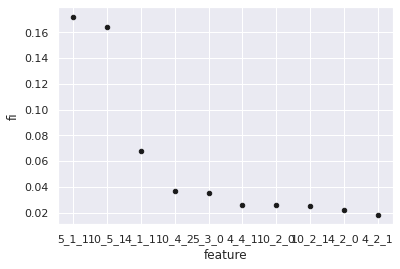

In [ ]:
fi_pf_ax = get_fi(basemodel_ax_pf, polyfeats,'polyfeatures')
fi_pf_ax[:10].plot.scatter('feature', 'fi', color='k')
print(fi_pf_ax[:10])

In [ ]:
pf_ax_fi_data = features_vs_r2(polyfeats, 'polyfeatures', y=y_classes['αx'], 
               model=basemodel_ax_pf, test_size=0.2, cv=5, niters=6, stratify=None, as_df=True)

Running iter 1
Number of features: 76
Size of training and test set: ((8400, 76), (2100, 76))
Computing cross-validation scores
Cross val-scores: 0.963 +- 0.00204
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s


Model Out-of-Bag score: 0.968
Test score: 0.968


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Running iter 2
Number of features: 38
Size of training and test set: ((8400, 38), (2100, 38))
Computing cross-validation scores
Cross val-scores: 0.962 +- 0.0016
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Out-of-Bag score: 0.966
Test score: 0.967

Running iter 3
Number of features: 19
Size of training and test set: ((8400, 19), (2100, 19))
Computing cross-validation scores
Cross val-scores: 0.954 +- 0.00248
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Model Out-of-Bag score: 0.958
Test score: 0.96


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Running iter 4
Number of features: 10
Size of training and test set: ((8400, 10), (2100, 10))
Computing cross-validation scores
Cross val-scores: 0.911 +- 0.00189
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Out-of-Bag score: 0.917
Test score: 0.919

Running iter 5
Number of features: 5
Size of training and test set: ((8400, 5), (2100, 5))
Computing cross-validation scores
Cross val-scores: 0.866 +- 0.00679
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Model Out-of-Bag score: 0.871
Test score: 0.87


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Running iter 6
Number of features: 3
Size of training and test set: ((8400, 3), (2100, 3))
Computing cross-validation scores
Cross val-scores: 0.756 +- 0.0037
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Model Out-of-Bag score: 0.764
Test score: 0.747



[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
pf_ax_fi_data

,n_features,features,model_obj,feat_imp,score_stats,oob_score,test_score
0,76,"[4_1_3, 4_1_2, 4_1_1, 4_1_0, 4_2_3, 4_2_2, 4_2...","(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",18 0.176749 54 0.144545 2 0.064599 6...,"[0.9633218552601569, 0.0020410276301418874]",0.967721,0.967701
1,38,18 5_1_1 54 10_5_1 2 4_1_1 6 ...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.193298 1 0.136094 2 0.073932 3...,"[0.9623568060957439, 0.0016043108520424796]",0.965616,0.966549
2,19,0 5_1_1 1 10_5_1 2 4_1_1 3 ...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.169386 1 0.165959 2 0.101388 4...,"[0.9543535793944035, 0.0024783406340570012]",0.957615,0.959875
3,10,0 5_1_1 1 10_5_1 2 4_1_1 4 ...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.204481 1 0.161299 2 0.119392 6 ...,"[0.9108646702328084, 0.0018948653977358054]",0.917412,0.918661
4,5,0 5_1_1 1 10_5_1 2 4_1_1 6 4_2_...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.285304 1 0.223944 2 0.186243 3 ...,"[0.8655003681542558, 0.006785975324634074]",0.870874,0.869772
5,3,0 5_1_1 1 10_5_1 2 4_1_1 Name: feat...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",1 0.346529 0 0.346080 2 0.307391 Name...,"[0.7560410014974425, 0.0037045444580511623]",0.764060,0.747487


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


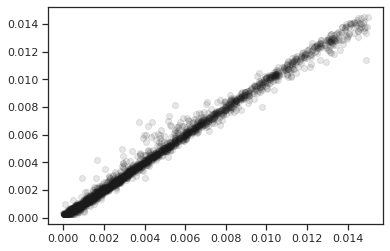

In [ ]:
y_pred_ax_pf = pf_ax_fi_data.iloc[0,2].predict(X_test_ax_pf)

plt.plot(y_test_ax_pf, y_pred_ax_pf,'ko',alpha=0.1)
plt.show()

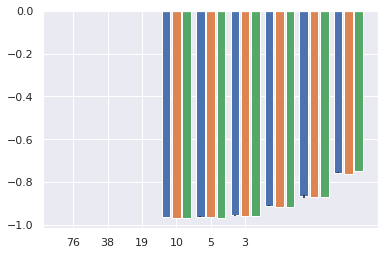

In [ ]:
fig, ax = plt.subplots()
get_r2_barplot(pf_ax_fi_data, ax, 'polyfeats')

### $\alpha _z$

In [ ]:
X_train_az_pf , X_test_az_pf, y_train_az_pf, y_test_az_pf = train_test_split(polyfeats, y_classes['αz'], test_size=0.2,
                                                     stratify=params['stencil_type'], random_state=101)

In [ ]:
basemodel_az_pf = RandomForestRegressor(n_estimators=100, min_samples_split=5, max_features=0.5, 
                           n_jobs=-1, oob_score=True, verbose=1)
basemodel_az_pf.fit(X_train_az_pf, y_train_az_pf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.2s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=1, warm_start=False)

In [ ]:
basemodel_az_pf.score(X_test_az_pf, y_test_az_pf)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


0.9673104945100637

In [ ]:
basemodel_az_pf.oob_score_

0.9677283822941208

#### FEature importance

    feature        fi order color
37   10_1_2  0.171702     2     g
53   10_5_2  0.080960     2     g
41   10_2_2  0.080177     2     g
6     4_2_1  0.060887     1     b
47   10_3_0  0.046071     0     r
50   10_4_1  0.036116     1     b
75  10_10_0  0.035217     0     r
43   10_2_0  0.033050     0     r
55   10_5_0  0.032369     0     r
70   10_9_1  0.028990     1     b


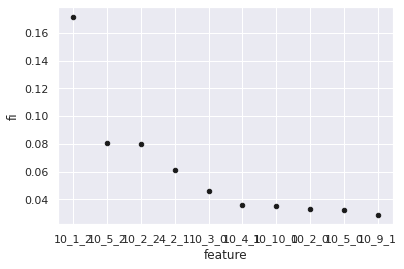

In [ ]:
fi_pf_az = get_fi(basemodel_az_pf, polyfeats,'polyfeatures')
fi_pf_az[:10].plot.scatter('feature', 'fi', color='k')
print(fi_pf_az[:10])

In [ ]:
pf_az_fi_data = features_vs_r2(polyfeats, 'polyfeatures', y=y_classes['αz'], 
               model=basemodel_az_pf, test_size=0.2, cv=5, niters=6, stratify=None, as_df=True)

Running iter 1
Number of features: 76
Size of training and test set: ((8400, 76), (2100, 76))
Computing cross-validation scores
Cross val-scores: 0.962 +- 0.00385
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s


Model Out-of-Bag score: 0.967
Test score: 0.969


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished



Running iter 2
Number of features: 38
Size of training and test set: ((8400, 38), (2100, 38))
Computing cross-validation scores
Cross val-scores: 0.963 +- 0.00381
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Out-of-Bag score: 0.966
Test score: 0.969

Running iter 3
Number of features: 19
Size of training and test set: ((8400, 19), (2100, 19))
Computing cross-validation scores
Cross val-scores: 0.954 +- 0.0042
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


Model Out-of-Bag score: 0.958
Test score: 0.963


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Running iter 4
Number of features: 10
Size of training and test set: ((8400, 10), (2100, 10))
Computing cross-validation scores
Cross val-scores: 0.932 +- 0.00567
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished


Model Out-of-Bag score: 0.939
Test score: 0.943


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Running iter 5
Number of features: 5
Size of training and test set: ((8400, 5), (2100, 5))
Computing cross-validation scores
Cross val-scores: 0.887 +- 0.00988
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Model Out-of-Bag score: 0.892
Test score: 0.902


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished



Running iter 6
Number of features: 3
Size of training and test set: ((8400, 3), (2100, 3))
Computing cross-validation scores
Cross val-scores: 0.705 +- 0.0132
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Out-of-Bag score: 0.712
Test score: 0.73



In [ ]:
pf_az_fi_data

,n_features,features,model_obj,feat_imp,score_stats,oob_score,test_score
0,76,"[4_1_3, 4_1_2, 4_1_1, 4_1_0, 4_2_3, 4_2_2, 4_2...","(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",37 0.201335 41 0.079438 6 0.062894 5...,"[0.9624087344548966, 0.00385096489012801]",0.966741,0.969039
1,38,37 10_1_2 41 10_2_2 6 4_2_1 53 ...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.200676 3 0.083068 1 0.074216 2...,"[0.9627504171675458, 0.00381276882891331]",0.966219,0.969107
2,19,0 10_1_2 3 10_5_2 1 10_2_2 2 ...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.191180 2 0.094561 1 0.084807 3...,"[0.9535357186360448, 0.004198500718670256]",0.958016,0.962653
3,10,0 10_1_2 2 10_2_2 1 10_5_2 3 ...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.215038 1 0.120642 6 0.103724 5 ...,"[0.9321635242400841, 0.0056736004148330195]",0.938972,0.943139
4,5,0 10_1_2 1 10_2_2 6 10_2_0 5 10...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.259927 4 0.219357 1 0.187689 3 ...,"[0.8865842697911468, 0.009880633284677687]",0.891952,0.901691
5,3,0 10_1_2 4 10_5_2 1 10_2_2 Name: feat...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.359511 2 0.342054 1 0.298435 Name...,"[0.7050022926345392, 0.013239295029792125]",0.711766,0.729715


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


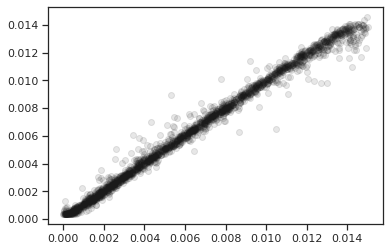

In [ ]:
y_pred_az_pf = pf_az_fi_data.iloc[0,2].predict(X_test_az_pf)

plt.plot(y_test_az_pf, y_pred_az_pf,'ko',alpha=0.1)
plt.show()

### Length scale

In [ ]:
X_train_ls_pf , X_test_ls_pf, y_train_ls_pf, y_test_ls_pf = train_test_split(polyfeats, y_classes['len_scale'], test_size=0.2,
                                                     stratify=params['stencil_type'], random_state=101)

In [ ]:
basemodel_ls_pf = RandomForestRegressor(n_estimators=100, min_samples_split=5, max_features=0.5, 
                           n_jobs=-1, oob_score=True, verbose=1)
basemodel_ls_pf.fit(X_train_ls_pf, y_train_ls_pf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.7s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=1, warm_start=False)

In [ ]:
basemodel_ls_pf.score(X_test_ls_pf, y_test_ls_pf)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


0.9417150080059641

In [ ]:
basemodel_ls_pf.oob_score_

0.9026209738003674

#### Feature importance

    feature        fi order color
35    5_5_0  0.125693     0     r
75  10_10_0  0.077663     0     r
42   10_2_1  0.076176     1     b
71   10_9_0  0.044797     0     r
58   10_6_1  0.039795     1     b
56   10_6_3  0.038696     3     y
15    4_4_0  0.037121     0     r
10    4_3_1  0.032240     1     b
70   10_9_1  0.024293     1     b
43   10_2_0  0.024013     0     r


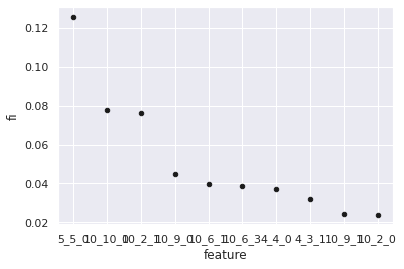

In [ ]:
fi_pf_ls = get_fi(basemodel_ls_pf, polyfeats,'polyfeatures')
fi_pf_ls[:10].plot.scatter('feature', 'fi', color='k')
print(fi_pf_ls[:10])

In [ ]:
pf_ls_fi_data = features_vs_r2(polyfeats, 'polyfeatures', y=y_classes['len_scale'], 
               model=basemodel_ls_pf, test_size=0.2, cv=5, niters=6, stratify=None, as_df=True)

Running iter 1
Number of features: 76
Size of training and test set: ((8400, 76), (2100, 76))
Computing cross-validation scores
Cross val-scores: 0.888 +- 0.0409
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.4s finished


Model Out-of-Bag score: 0.897
Test score: 0.929


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished



Running iter 2
Number of features: 38
Size of training and test set: ((8400, 38), (2100, 38))
Computing cross-validation scores
Cross val-scores: 0.893 +- 0.0344
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s finished


Model Out-of-Bag score: 0.9
Test score: 0.934


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished



Running iter 3
Number of features: 19
Size of training and test set: ((8400, 19), (2100, 19))
Computing cross-validation scores
Cross val-scores: 0.875 +- 0.0407
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


Model Out-of-Bag score: 0.882
Test score: 0.923


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Running iter 4
Number of features: 10
Size of training and test set: ((8400, 10), (2100, 10))
Computing cross-validation scores
Cross val-scores: 0.858 +- 0.0454
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Model Out-of-Bag score: 0.853
Test score: 0.911


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished



Running iter 5
Number of features: 5
Size of training and test set: ((8400, 5), (2100, 5))
Computing cross-validation scores
Cross val-scores: 0.735 +- 0.062
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Model Out-of-Bag score: 0.74
Test score: 0.815


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished



Running iter 6
Number of features: 3
Size of training and test set: ((8400, 3), (2100, 3))
Computing cross-validation scores
Cross val-scores: 0.599 +- 0.055
Done! 
 Fitting model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s


Model Out-of-Bag score: 0.614
Test score: 0.668



[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
pf_ls_fi_data

,n_features,features,model_obj,feat_imp,score_stats,oob_score,test_score
0,76,"[4_1_3, 4_1_2, 4_1_1, 4_1_0, 4_2_3, 4_2_2, 4_2...","(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",35 0.128371 75 0.076048 42 0.067807 5...,"[0.8878206421537399, 0.04089477380407386]",0.897473,0.929304
1,38,35 5_5_0 75 10_10_0 42 10_2_1 56 ...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.134022 1 0.077071 2 0.076564 4...,"[0.8929605964642876, 0.03438524046349966]",0.900226,0.934338
2,19,0 5_5_0 1 10_10_0 2 10_2_1 4 ...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.148897 2 0.086085 1 0.081452 3...,"[0.8746364359014809, 0.04070055850211153]",0.881887,0.923377
3,10,0 5_5_0 2 10_2_1 1 10_10_0 3 ...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.161062 3 0.117259 1 0.111675 2 ...,"[0.8575212960321406, 0.04539699386045555]",0.852559,0.910701
4,5,0 5_5_0 3 10_9_0 1 10_2_1 2 10...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.241752 2 0.220152 1 0.209839 3 ...,"[0.73517297806082, 0.06195289641120766]",0.740447,0.815348
5,3,0 5_5_0 2 10_2_1 1 10_9_0 Name: feat...,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0 0.381397 2 0.328002 1 0.290601 Name...,"[0.5987391773571403, 0.054989053210850646]",0.614327,0.667951


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


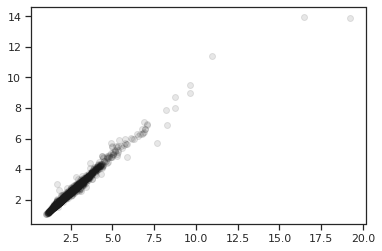

In [ ]:
y_pred_ls_pf = pf_ls_fi_data.iloc[0,2].predict(X_test_ls_pf)

plt.plot(y_test_ls_pf, y_pred_ls_pf,'ko',alpha=0.1)
plt.show()

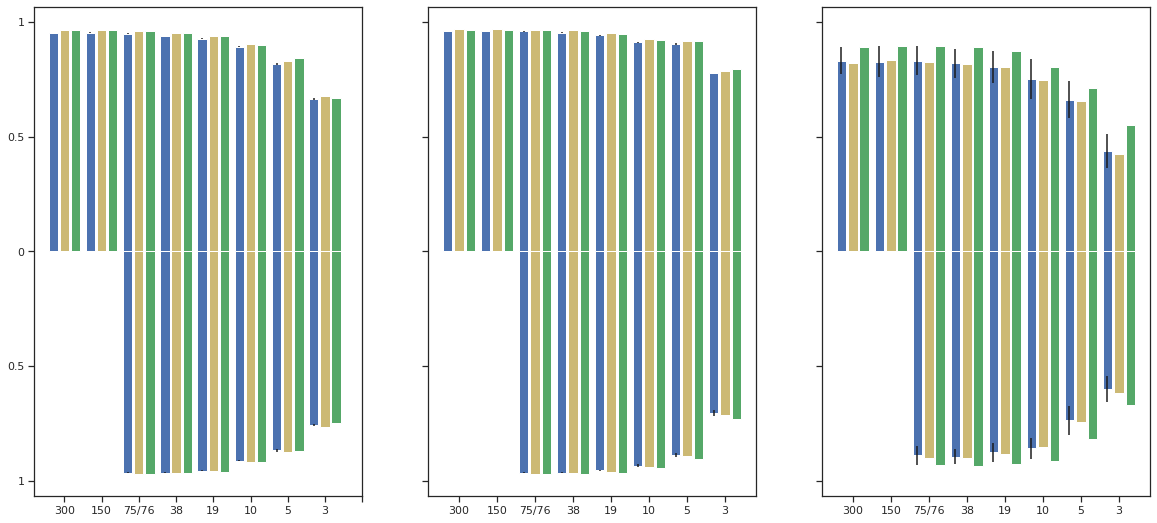

In [ ]:
sns.set_style('ticks')

#fig, ax1 = plt.subplots()
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,9),sharex=True, sharey=True)

get_r2_barplot(ts_ax_fi_data, ax1, 'timeseries')
get_r2_barplot(ts_az_fi_data, ax2, 'timeseries')
get_r2_barplot(ts_ls_fi_data, ax3, 'timeseries')


get_r2_barplot(pf_ax_fi_data, ax1, 'polyfeats')
get_r2_barplot(pf_az_fi_data, ax2, 'polyfeats')
get_r2_barplot(pf_ls_fi_data, ax3, 'polyfeats')

ax1.set(xticks=np.arange(9),xticklabels=['300','150', '75/76', '38', '19', '10', '5','3'],
        yticks=np.linspace(-1,1,5), yticklabels=['1','0.5','0','0.5','1'])

plt.show()

# Feature importance plots

In [ ]:
# Timeseries
fi_ax_ts = get_fi(ts_ax_fi_data.iloc[0,2], rscl_df , "timeseries")
fi_az_ts = get_fi(ts_az_fi_data.iloc[0,2], rscl_df , "timeseries")
fi_ls_ts = get_fi(ts_ls_fi_data.iloc[0,2], rscl_df , "timeseries")
fi_ax_ts_10feat = get_fi(ts_ax_fi_data.iloc[5,2], rscl_df[ts_ax_fi_data.iloc[5,1]] , "timeseries")
fi_az_ts_10feat = get_fi(ts_az_fi_data.iloc[5,2], rscl_df[ts_az_fi_data.iloc[5,1]] , "timeseries")
fi_ls_ts_10feat = get_fi(ts_ls_fi_data.iloc[5,2], rscl_df[ts_ls_fi_data.iloc[5,1]] , "timeseries")

for df in (fi_ax_ts,fi_az_ts,fi_ls_ts,fi_ax_ts_10feat, fi_az_ts_10feat, fi_ls_ts_10feat):
    df['timestamp'] = df['feature'].apply(lambda x : int(x[4:]))


# Polynomial features
fi_ax_pf = get_fi(pf_ax_fi_data.iloc[0,2], polyfeats , "polyfeatures")
fi_az_pf = get_fi(pf_az_fi_data.iloc[0,2], polyfeats , "polyfeatures")
fi_ls_pf = get_fi(pf_ls_fi_data.iloc[0,2], polyfeats , "polyfeatures")

In [1]:
plt.plot(fi_ax_ts_10feat.timestamp, fi_ax_ts_10feat.fi,'b--',markersize=15, alpha=0.1)

NameError: ignored

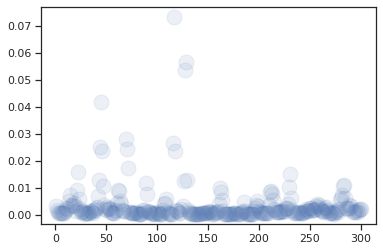

In [ ]:
plt.plot(fi_ax_ts.timestamp, fi_ax_ts.fi,'bo',markersize=15, alpha=0.1)

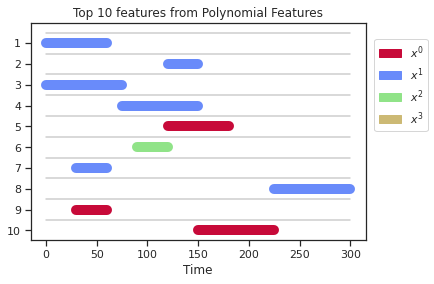

In [ ]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots()
intervals = FeaturePlot(300).get_intervals([4,5,10])
fi_df2plot(get_fi(pf_ax_fi_data.iloc[0,2], polyfeats , "polyfeatures"), 10, intervals, ax)
ax.legend(bbox_to_anchor=[1.01,1])

plt.title("Top 10 features from Polynomial Features")


## setting up legend
color_arr = ['#c70a39','#698bfa','#90e388','y']

red_patch = mpatches.Patch(color=color_arr[0], label=r'$x^0$')
bl_patch = mpatches.Patch(color=color_arr[1], label=r'$x^1$')
green_patch = mpatches.Patch(color=color_arr[2], label=r'$x^2$')
yl_patch = mpatches.Patch(color=color_arr[3], label=r'$x^3$')
ax.legend(handles=[red_patch, bl_patch, green_patch, yl_patch], bbox_to_anchor=[1.01,0.95])

ax.set(yticks=np.arange(1,11), yticklabels=np.arange(10,0,-1))
plt.show()

# Final plot

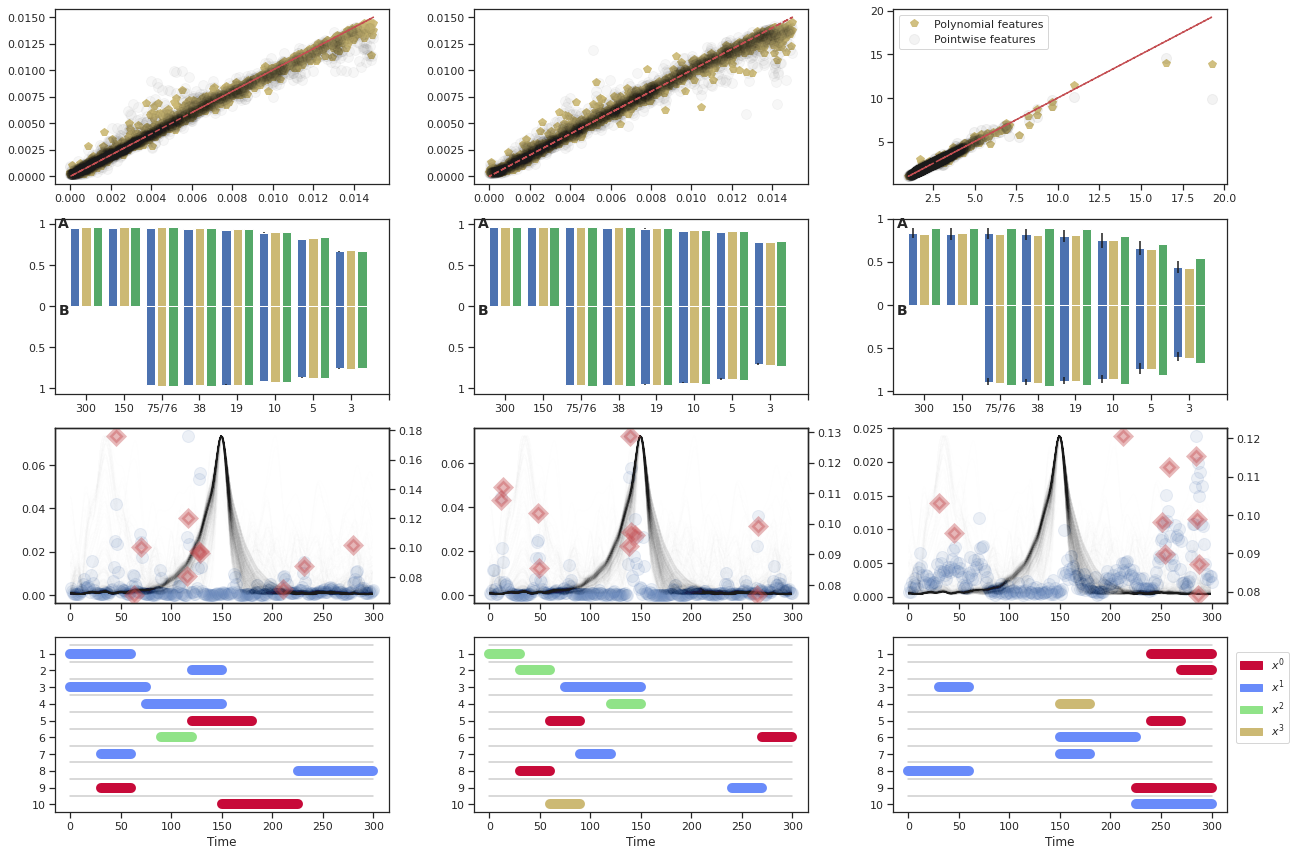

In [ ]:
sns.set_style('ticks')
fig = plt.figure(figsize=(18,12))
ax = fig.add_gridspec(8,6)

# Scatter plots
ax1 = fig.add_subplot(ax[0:2,0:2])
ax2 = fig.add_subplot(ax[0:2,2:4])
ax3 = fig.add_subplot(ax[0:2,4:6])

ax1.plot(y_test_ax_pf, y_pred_ax_pf,'yo',alpha=0.9,marker='p',markersize=8)
ax2.plot(y_test_az_pf, y_pred_az_pf,'yo',alpha=0.9,marker='p',markersize=8)
ax3.plot(y_test_ls_pf, y_pred_ls_pf,'yo',alpha=0.9,marker='p',markersize=8, label='Polynomial features')

ax1.plot(y_test_ax_ts, y_pred_ax_ts,'ko',alpha=0.03,markersize=10)
ax2.plot(y_test_az_ts, y_pred_az_ts,'ko',alpha=0.03,markersize=10)
ax3.plot(y_test_ls_ts, y_pred_ls_ts,'ko',alpha=0.05,markersize=10, label='Pointwise features')

ax3.legend()

ax1.plot(y_test_ax_ts, y_test_ax_ts, 'r--')
ax2.plot(y_test_az_ts, y_test_az_ts, 'r--')
ax3.plot(y_test_ls_ts, y_test_ls_ts, 'r--')

# R2 bar plots
ax4 = fig.add_subplot(ax[2:4,0:2])
ax5 = fig.add_subplot(ax[2:4,2:4])
ax6 = fig.add_subplot(ax[2:4,4:6])

get_r2_barplot(ts_ax_fi_data, ax4, 'timeseries')
get_r2_barplot(ts_az_fi_data, ax5, 'timeseries')
get_r2_barplot(ts_ls_fi_data, ax6, 'timeseries')


get_r2_barplot(pf_ax_fi_data, ax4, 'polyfeats')
get_r2_barplot(pf_az_fi_data, ax5, 'polyfeats')
get_r2_barplot(pf_ls_fi_data, ax6, 'polyfeats')

for axes in [ax4,ax5,ax6]:
    axes.set(xticks=np.arange(9),xticklabels=['300','150', '75/76', '38', '19', '10', '5','3'],
        yticks=np.linspace(-1,1,5), yticklabels=['1','0.5','0','0.5','1'])
    axes.text(0.01,0.95,'A', fontweight='bold', fontsize=14,  transform=axes.transAxes)
    axes.text(0.01,0.45,'B', fontweight='bold', fontsize=14,  transform=axes.transAxes)


# Feature importance plots
ax7 = fig.add_subplot(ax[4:6,0:2])
ax8 = fig.add_subplot(ax[4:6,2:4])
ax9 = fig.add_subplot(ax[4:6,4:6])

ax7.plot(fi_ax_ts.timestamp, fi_ax_ts.fi,'bo',markersize=12, alpha=0.1)
ax8.plot(fi_az_ts.timestamp, fi_az_ts.fi,'bo',markersize=12, alpha=0.1)
ax9.plot(fi_ls_ts.timestamp, fi_ls_ts.fi,'bo',markersize=12, alpha=0.1)

### another axis for echo curve
for axes,df in zip([ax7,ax8,ax9],[fi_ax_ts_10feat,fi_az_ts_10feat,fi_ls_ts_10feat]):
    ax_echocopy = axes.twinx()
    ax_t10feat = axes.twinx()
    for i in range(0,10500,15):
        ax_echocopy.plot(rscl_data[i,:],'k',alpha=0.002)
    ax_echocopy.set_yticks([])
    ax_t10feat.plot(df.timestamp, df.fi, 'rD', markersize=10, alpha=0.4, markeredgewidth=5)


# Polynomial Feature importance plots
ax10 = fig.add_subplot(ax[6:8,0:2])
ax11 = fig.add_subplot(ax[6:8,2:4])
ax12 = fig.add_subplot(ax[6:8,4:6])

intervals = FeaturePlot(300).get_intervals([4,5,10])
fi_df2plot(get_fi(pf_ax_fi_data.iloc[0,2], polyfeats , "polyfeatures"), 10, intervals, ax10)
fi_df2plot(get_fi(pf_az_fi_data.iloc[0,2], polyfeats , "polyfeatures"), 10, intervals, ax11)
fi_df2plot(get_fi(pf_ls_fi_data.iloc[0,2], polyfeats , "polyfeatures"), 10, intervals, ax12)

## setting up legend
for axes in (ax10,ax11,ax12):
    axes.get_legend().remove()
    axes.set(yticks=np.arange(1,11), yticklabels=np.arange(10,0,-1))

color_arr = ['#c70a39','#698bfa','#90e388','y']

red_patch = mpatches.Patch(color=color_arr[0], label=r'$x^0$')
bl_patch = mpatches.Patch(color=color_arr[1], label=r'$x^1$')
green_patch = mpatches.Patch(color=color_arr[2], label=r'$x^2$')
yl_patch = mpatches.Patch(color=color_arr[3], label=r'$x^3$')
ax12.legend(handles=[red_patch, bl_patch, green_patch, yl_patch], bbox_to_anchor=[1.01,0.95])



plt.tight_layout()
plt.show()